In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_general_model.npz', allow_pickle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Access the saved data from the .npz file
all_EventCount = data['all_EventCount']
all_DeviceActiveCount = data['all_DeviceActiveCount']
all_DeviceProbability = data['all_DeviceProbability']
all_DeviceAlarmStatus = data['all_DeviceAlarmStatus']
all_DeviceStatus = data['all_DeviceStatus']
all_DeviceLocations = data['all_DeviceLocations']
all_DeviceLocationsPolar = data['all_DeviceLocationsPolar']
all_EventLocations = data['all_EventLocations']
all_EventLocationsPolar = data['all_EventLocationsPolar']
device_count = data['device_count']
event_count = data['event_count']
bs_location = data['bs_location']
bs_radius = data['bs_radius']
k = data['k']
sparsity = data['sparsity']
num_samples = data['num_samples']

In [ ]:
# Generate unique pilots
def generate_pilots(num_pilots, seq_length):
  pilots = np.zeros((num_pilots, seq_length), dtype=complex)
  seen_pilots = set()  # To track already generated pilots

  for i in range(num_pilots):
    while True:
      # Generate random QPSK symbols (0, 1, 2, 3)
      symbols = np.random.randint(0, 4, seq_length)

      # Generate QPSK symbols: Exp(1j * (np.pi / 2) * (symbol + 1/2)) to map symbols to QPSK constellation
      qpsk_symbols = np.exp(1j * (np.pi / 2) * (symbols + 1 / 2)) * np.sqrt(2)

      # Normalize the pilot sequence
      pilot = qpsk_symbols / np.sqrt(seq_length)

      # Check if this pilot sequence has already been generated
      pilot_tuple = tuple(pilot)  # Convert to tuple to store in set (tuples are hashable)

      if pilot_tuple not in seen_pilots:  # If it's a unique sequence
        pilots[i, :] = pilot  # Store the pilot
        seen_pilots.add(pilot_tuple)  # Mark this pilot sequence as seen
        break  # Exit while loop and move to the next pilot

  return pilots

In [ ]:
# Given SNR in dB
def snr_to_linear(SNR_dB):
  return 10 ** (SNR_dB / 10)

In [ ]:
# Simulate the communication model for one SNR level and one time step
def simulate_communication(SNR_dB, theta, Gamma, Z, seq_length):
  # Convert SNR from dB to linear scale
  SNR = 10 ** (SNR_dB / 10)

  # Signal power calculation
  signal_power = np.mean(np.abs(np.dot(theta, Z))**2)

  # Noise power calculation based on SNR
  noise_power = signal_power / SNR

  # Generate noise (Gaussian)
  noise = np.sqrt(noise_power / 2) * (np.random.randn(seq_length) + 1j * np.random.randn(seq_length))

  # Received signal
  received_signal = np.dot(theta, Z) + noise

  return noise, received_signal

In [ ]:
snr_db_array = np.arange(4, 25, 4)  # Array of SNR values: [4, 8, 12, 16, 20, 24]
seq_length = round(2.5 * sparsity)

In [ ]:
def run_simulations(device_count, bs_location, bs_radius, k, sparsity, SNR_dB_Array, sample_index, DeviceStatus, seq_length):
  # Generate pilots for the sample (same pilots for all SNR levels)
  pilots = generate_pilots(device_count, seq_length)
  theta = pilots.T  # Same theta for all SNR levels

  # Generate Z (signal with noise)
  Z = np.sqrt(1 / 2) * (np.random.multivariate_normal(np.zeros(device_count), np.diag(DeviceStatus)) +
                        1j * np.random.multivariate_normal(np.zeros(device_count), np.diag(DeviceStatus)))

  # Arrays to store noise and received signals for all SNR levels
  all_snr_noise = np.zeros((len(SNR_dB_Array), seq_length), dtype=complex)  # Store noise for all SNRs
  all_snr_received_signal = np.zeros((len(SNR_dB_Array), seq_length), dtype=complex)  # Store received signal for all SNRs

  # Simulate communication for each SNR level
  for snr_index, SNR_dB in enumerate(SNR_dB_Array):
    print(f"  Simulating for SNR = {SNR_dB} dB (Index {snr_index})...")

    # Simulate communication for the current SNR level and sample
    noise, received_signal = simulate_communication(SNR_dB, theta, DeviceStatus, Z, seq_length)

    # Store results in the arrays
    all_snr_noise[snr_index] = noise
    all_snr_received_signal[snr_index] = received_signal

    # Print for feedback
    print(f"    Simulated SNR = {SNR_dB} dB for Sample {sample_index + 1}")

  return theta, DeviceStatus, Z, all_snr_noise, all_snr_received_signal


In [ ]:
# Define arrays to store results
all_theta = np.zeros((num_samples, seq_length, device_count), dtype=complex)
all_gamma = np.zeros((num_samples, device_count), dtype=bool)
all_Z = np.zeros((num_samples, device_count), dtype=complex)
all_noise = np.zeros((num_samples, len(snr_db_array), seq_length), dtype=complex)
all_received_signal = np.zeros((num_samples, len(snr_db_array), seq_length), dtype=complex)

# Loop through each sample from the loaded data
for sample_index in range(num_samples):
  print(f"\nRunning simulation for Sample {sample_index + 1}...")

  # Extract the device status for the current sample
  DeviceStatus = all_DeviceStatus[sample_index]

  # Run the simulation for this sample, using the saved parameters
  # Generate pilots and simulate for each SNR level
  theta, gamma, Z, all_snr_noise, all_snr_received_signal = run_simulations(
      device_count, bs_location, bs_radius, k, sparsity, snr_db_array, sample_index, DeviceStatus, seq_length
  )

  # Assign results directly to the pre-allocated arrays
  all_theta[sample_index, :, :] = theta
  all_gamma[sample_index, :] = gamma
  all_Z[sample_index, :] = Z
  all_noise[sample_index, :, :] = all_snr_noise
  all_received_signal[sample_index, :, :] = all_snr_received_signal

  print(f"Completed simulation for Sample {sample_index + 1}")

# Save all collected results to a .npz file
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/e4_communication_simulation.npz',
         all_theta=all_theta,
         all_gamma=all_gamma,
         all_Z=all_Z,
         all_noise=all_noise,
         all_received_signal=all_received_signal,
         seq_length=seq_length,
         snr_db_array=snr_db_array)

print("All simulation results have been saved to 'communication_simulation_results_all_samples.npz'.")


Streaming output truncated to the last 5000 lines.
    Simulated SNR = 20 dB for Sample 667
  Simulating for SNR = 24 dB (Index 5)...
    Simulated SNR = 24 dB for Sample 667
Completed simulation for Sample 667

Running simulation for Sample 668...
  Simulating for SNR = 4 dB (Index 0)...
    Simulated SNR = 4 dB for Sample 668
  Simulating for SNR = 8 dB (Index 1)...
    Simulated SNR = 8 dB for Sample 668
  Simulating for SNR = 12 dB (Index 2)...
    Simulated SNR = 12 dB for Sample 668
  Simulating for SNR = 16 dB (Index 3)...
    Simulated SNR = 16 dB for Sample 668
  Simulating for SNR = 20 dB (Index 4)...
    Simulated SNR = 20 dB for Sample 668
  Simulating for SNR = 24 dB (Index 5)...
    Simulated SNR = 24 dB for Sample 668
Completed simulation for Sample 668

Running simulation for Sample 669...
  Simulating for SNR = 4 dB (Index 0)...
    Simulated SNR = 4 dB for Sample 669
  Simulating for SNR = 8 dB (Index 1)...
    Simulated SNR = 8 dB for Sample 669
  Simulating for SNR 

Shape of Z: (400,)
Shape of Gamma: (400,)
Shape of received_signal: (50,)
Shape of noise: (50,)


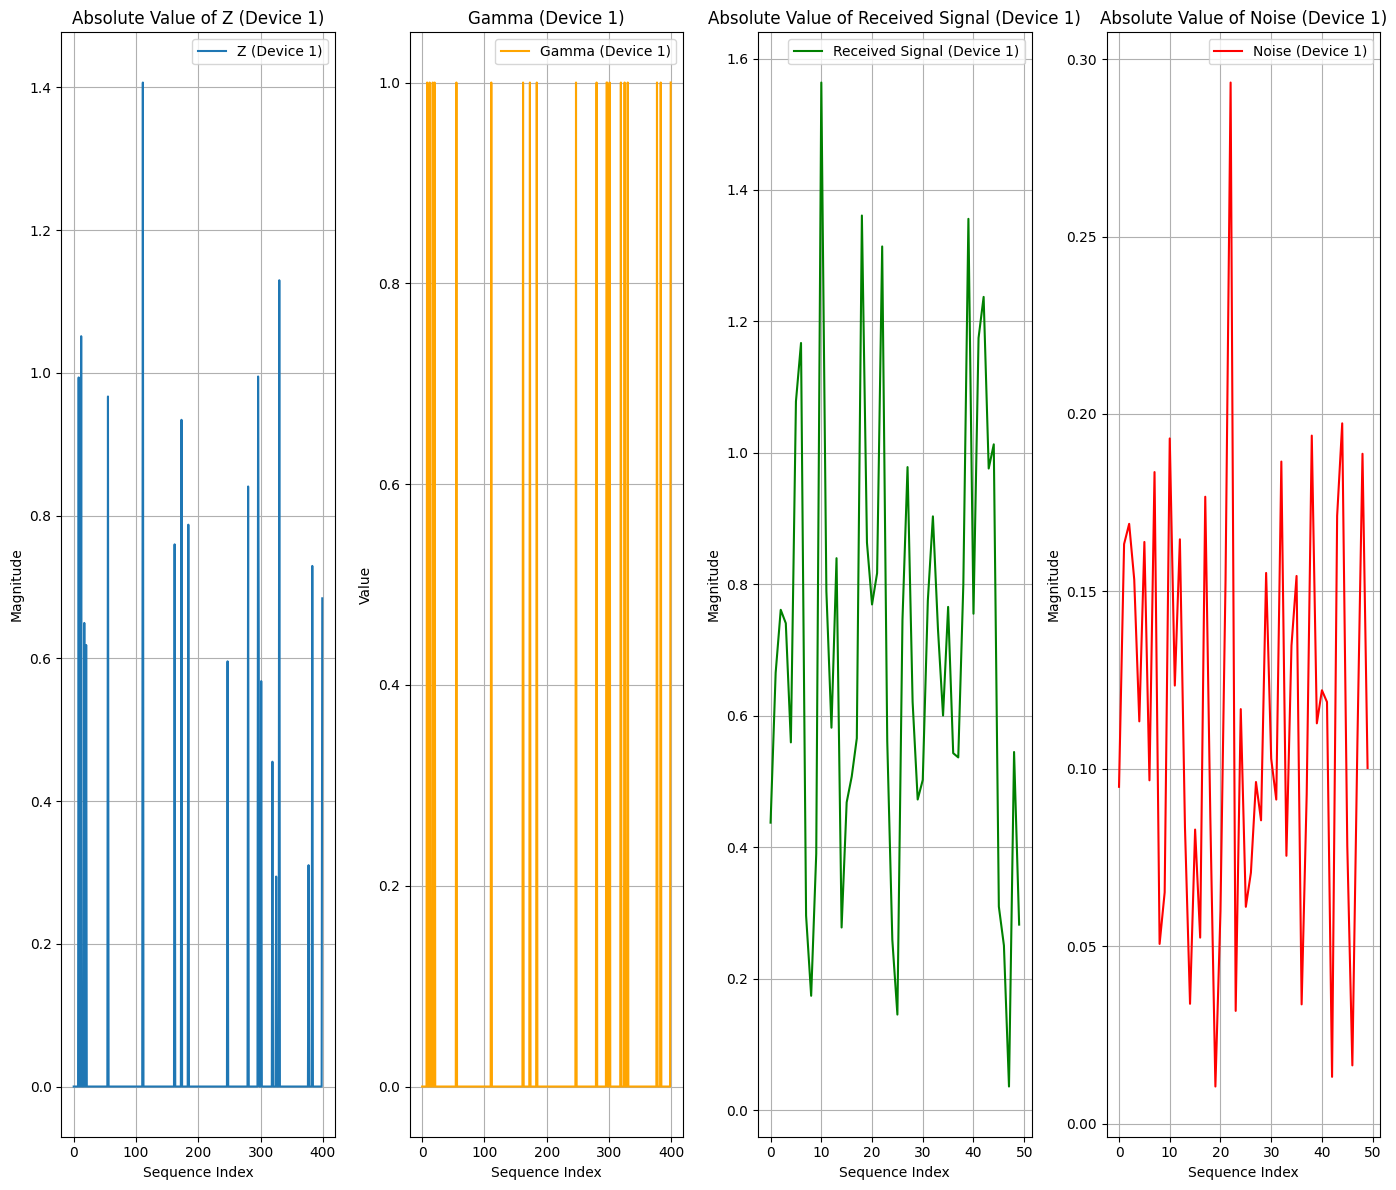

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved data for the simulation
simulation_data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_communication_simulation.npz', allow_pickle=True)

# Select sample index (modify if needed)
sample_index = 0  # Change this to the sample index you wish to view
snr_index = 3  # Change this to the sample index you wish to view

# Extract the 'Z', 'Gamma', 'Received Signal', and 'Noise' data for the selected sample
Z = simulation_data['all_Z'][sample_index]
Gamma = simulation_data['all_gamma'][sample_index]
received_signal = simulation_data['all_received_signal'][sample_index, snr_index]
noise = simulation_data['all_noise'][sample_index, snr_index]

# Print the shapes of these arrays for debugging
print("Shape of Z:", Z.shape)
print("Shape of Gamma:", Gamma.shape)
print("Shape of received_signal:", received_signal.shape)
print("Shape of noise:", noise.shape)

# If the shape of Z is 1-dimensional, we need to treat it differently
# Otherwise, proceed as expected for 2D arrays

# Number of devices in the selected sample
num_devices = Z.shape[0] if len(Z.shape) > 1 else 1  # Adjust if Z is 1D

# Create a figure to display the absolute value of Z, Gamma, received signal, and noise for all devices
plt.figure(figsize=(14, 12))

# Loop through each device and plot the absolute value for Z, Gamma, received signal, and noise
for device_index in range(num_devices):
    # Calculate the absolute value (magnitude) of Z, received_signal, and noise for the selected device
    if len(Z.shape) > 1:  # If Z is 2D, we can index by device
        Z_abs = np.abs(Z[device_index, :])
    else:  # If Z is 1D (single device), just take the absolute value
        Z_abs = np.abs(Z)

    received_signal_abs = np.abs(received_signal[device_index, :]) if len(received_signal.shape) > 1 else np.abs(received_signal)
    noise_abs = np.abs(noise[device_index, :]) if len(noise.shape) > 1 else np.abs(noise)
    gamma_value = Gamma[device_index, :] if len(Gamma.shape) > 1 else Gamma

    # Plot absolute value of Z for this device
    plt.subplot(num_devices, 4, device_index * 4 + 1)
    plt.plot(Z_abs, label=f'Z (Device {device_index + 1})')
    plt.title(f'Absolute Value of Z (Device {device_index + 1})')
    plt.xlabel('Sequence Index')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.legend()

    # Plot Gamma for this device (Binary plot for Gamma, as it's a boolean array)
    plt.subplot(num_devices, 4, device_index * 4 + 2)
    plt.plot(gamma_value, label=f'Gamma (Device {device_index + 1})', color='orange')
    plt.title(f'Gamma (Device {device_index + 1})')
    plt.xlabel('Sequence Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    # Plot absolute value of received signal for this device
    plt.subplot(num_devices, 4, device_index * 4 + 3)
    plt.plot(received_signal_abs, label=f'Received Signal (Device {device_index + 1})', color='green')
    plt.title(f'Absolute Value of Received Signal (Device {device_index + 1})')
    plt.xlabel('Sequence Index')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.legend()

    # Plot absolute value of noise for this device
    plt.subplot(num_devices, 4, device_index * 4 + 4)
    plt.plot(noise_abs, label=f'Noise (Device {device_index + 1})', color='red')
    plt.title(f'Absolute Value of Noise (Device {device_index + 1})')
    plt.xlabel('Sequence Index')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
theta

array([[ 0.14142136-0.14142136j, -0.14142136+0.14142136j,
        -0.14142136+0.14142136j, ..., -0.14142136+0.14142136j,
        -0.14142136+0.14142136j, -0.14142136-0.14142136j],
       [ 0.14142136+0.14142136j, -0.14142136-0.14142136j,
        -0.14142136-0.14142136j, ..., -0.14142136-0.14142136j,
         0.14142136-0.14142136j,  0.14142136+0.14142136j],
       [ 0.14142136+0.14142136j, -0.14142136+0.14142136j,
         0.14142136+0.14142136j, ...,  0.14142136-0.14142136j,
         0.14142136+0.14142136j, -0.14142136-0.14142136j],
       ...,
       [-0.14142136+0.14142136j,  0.14142136-0.14142136j,
         0.14142136-0.14142136j, ...,  0.14142136+0.14142136j,
         0.14142136-0.14142136j, -0.14142136-0.14142136j],
       [-0.14142136+0.14142136j,  0.14142136+0.14142136j,
        -0.14142136+0.14142136j, ..., -0.14142136-0.14142136j,
         0.14142136-0.14142136j,  0.14142136+0.14142136j],
       [ 0.14142136-0.14142136j, -0.14142136-0.14142136j,
         0.14142136-0.14142136